In [7]:
from pandas_datareader import data
from pandas_datareader._utils import RemoteDataError
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import csv
import re
from datetime import datetime

import os.path
from os import path
import time

# import sklearn
# import scipy

# from sklearn.naive_bayes import GaussianNB
# import lightgbm as lightgbm
# from xgboost import XGBClassifier
# import keras

# Get Started
# https://github.com/Refinitiv-API-Samples/Article.EikonDataAPI.DotNet.Library
# API limits
# https://developers.refinitiv.com/en/api-catalog/eikon/eikon-data-api/documentation?content=49692&type=documentation_item
import eikon as ek 

from pylab import rcParams
plt.rcParams['figure.figsize'] = 16, 8

In [8]:
fontsize_reg = 12
fontsize_title = 16
from pylab import rcParams
rcParams['figure.facecolor'] = '1'
rcParams['figure.figsize'] = [8.0, 3.5]
rcParams['figure.dpi'] = 80
rcParams['savefig.dpi'] = 600

rcParams['font.size'] = 12
rcParams['legend.fontsize'] = 'large'
rcParams['figure.titlesize'] = 'large'

In [9]:
# Зададим path для папки проекта и для папок файлов
path_project_folder = 'C:/DAN/t_systems/trade_project/'
folder_name_headlines = 'backup_headlines/'
folder_name_logger = 'logger/'

In [18]:
# зададим API ключ
ek.set_app_key('ccebd1ff788d4574818be93e35c4741925ac214e')

In [10]:
rics_german_df = pd.read_excel(path_project_folder + 'rics_german_excel.xlsx')
sort_cols = ['DAX', 'German_telecom', 'Company Market Cap']
rics_german_df = rics_german_df.sort_values(by=sort_cols, ascending=False) # .reset_index(drop=True)
rics_german_df.index = range(0, len(rics_german_df))
rics_german_df

,ric,Company Common Name,Country of Exchange,Primary Country of Risk,TRBC Industry Group Name,TRBC Industry Name,Price Close,Company Market Cap,DAX,German_telecom
0,DTEGn.DE,Deutsche Telekom AG,Germany,Germany,Telecommunications Services,Integrated Telecommunications Services,18.032030,8.580246e+10,1,1
1,SAPG.DE,SAP SE,Germany,Germany,Software & IT Services,Software,122.335901,1.501916e+11,1,0
2,SIEGn.DE,Siemens AG,Germany,Germany,Consumer Goods Conglomerates,Consumer Goods Conglomerates,139.347250,1.183675e+11,1,0
3,ALVG.DE,Allianz SE,Germany,Germany,Insurance,Multiline Insurance & Brokers,235.534278,9.704549e+10,1,0
4,VOWG_p.DE,Volkswagen AG,Germany,Germany,Automobiles & Auto Parts,Auto & Truck Manufacturers,182.653284,9.619011e+10,1,0
...,...,...,...,...,...,...,...,...,...,...
1486,IXM0392.DE,MSCI Pac ex Jap ETF,Germany,NaN,NaN,NaN,164.045417,NaN,0,0
1487,IXM0402.DE,MSCI Canada ETF,Germany,NaN,NaN,NaN,147.258410,NaN,0,0
1488,IXM0422.DE,MSCI USA ETF,Germany,NaN,NaN,NaN,368.704250,NaN,0,0
1489,IXM0432.DE,MSCI Jap ETF,Germany,NaN,NaN,NaN,179.058138,NaN,0,0


In [11]:
condition_german = rics_german_df['Country of Exchange'] == 'Germany'
condition_telecom = rics_german_df['TRBC Industry Group Name'] == 'Telecommunications Services'
rics_german_telekom_df = rics_german_df[condition_german & condition_telecom]
rics_german_telekom_df[['ric', 'Company Common Name', 'Company Market Cap', 'DAX', 'German_telecom']]

,ric,Company Common Name,Company Market Cap,DAX,German_telecom
0,DTEGn.DE,Deutsche Telekom AG,8.580246e+10,1,1
27,O2Dn.DE,Telefonica Deutschland Holding AG,8.088962e+09,0,1
28,UTDI.DE,United Internet AG,7.962405e+09,0,1
29,DRIG.DE,1&1 Drillisch AG,4.331541e+09,0,1
30,FNTGn.DE,freenet AG,2.614030e+09,0,1
31,TC1n.DE,Tele Columbus AG,3.688837e+08,0,1
32,NFN.DE,NFON AG,3.245050e+08,0,1
33,E4CG.DE,Ecotel Communication AG,3.558930e+07,0,1
34,PH6.F,Philion SE,2.065664e+05,0,1


In [12]:
condition_dax = (rics_german_df['DAX'] == 1) & (rics_german_df['German_telecom'] != 1)
rics_dax = rics_german_df[condition_dax]
rics_dax[['ric', 'Company Common Name', 'Company Market Cap', 'DAX', 'German_telecom']]

,ric,Company Common Name,Company Market Cap,DAX,German_telecom
1,SAPG.DE,SAP SE,1.501916e+11,1,0
2,SIEGn.DE,Siemens AG,1.183675e+11,1,0
3,ALVG.DE,Allianz SE,9.704549e+10,1,0
4,VOWG_p.DE,Volkswagen AG,9.619011e+10,1,0
5,DAIGn.DE,Daimler AG,7.532200e+10,1,0
6,BASFn.DE,BASF SE,7.222737e+10,1,0
7,ADSGn.DE,Adidas AG,7.062461e+10,1,0
8,DPWGn.DE,Deutsche Post AG,5.932596e+10,1,0
9,BMWG.DE,Bayerische Motoren Werke AG,5.780708e+10,1,0
10,BAYGn.DE,Bayer AG,5.621811e+10,1,0


In [19]:
def get_name_of_latest_file_in_folder(folder_name):
    files_creation_dates = pd.DataFrame(data = [], columns=[
        "folder_name", "file_name", "num_time", "str_time"
    ])

    files_creation_dates['file_name'] = os.listdir(folder_name)
    files_creation_dates['folder_name'] = folder_name
    files_creation_dates['file_folder_and_name'] = files_creation_dates['folder_name'] + files_creation_dates['file_name']
    files_creation_dates
    for i in range(0, len(files_creation_dates)):
        file_folder_and_name = files_creation_dates['file_folder_and_name'][i]
        files_creation_dates['num_time'][i] = os.path.getctime(file_folder_and_name)
        files_creation_dates['str_time'][i] = time.ctime(os.path.getctime(file_folder_and_name))

    most_latest_file_dir = files_creation_dates.sort_values(by=['num_time'], ascending=False)['file_folder_and_name'].iloc[0]
    
    return most_latest_file_dir

In [80]:
# Создадим df, в который будем сохранять вообще все новости.

# Можем создать пустой df, куда будем добавлять все новости
# all_headlines_df = pd.DataFrame(data = [], columns=["ric", "versionCreated", "headline", "storyId", "sourceCode", "story"])

# Но если мы уже сохраняли файл, достанем самый свежий из папки
most_latest_file = get_name_of_latest_file_in_folder(path_project_folder + folder_name_headlines)
all_headlines_df = pd.read_csv(most_latest_file, sep='~')
all_headlines_df['versionCreated'] = pd.to_datetime(all_headlines_df['versionCreated'])
print(all_headlines_df.shape, most_latest_file)

(56779, 6) C:/DAN/t_systems/trade_project/backup_headlines/all_headlines_df_2021-01-05_v9.csv


In [81]:
# Создадим подобие logger'а 

# quasi_logger = pd.DataFrame(data = [], columns=[
#     'ric_i', 'ric_now', 'headlines_slice_i', 'headlines_number',
#     'up_to_date_ric', 'story_i', 'story_id_now', 'story_is_success', 
#     'date_time',
# ])

# Так как у нас уже есть созданный logger, подгрузим его
most_latest_file = get_name_of_latest_file_in_folder(path_project_folder + folder_name_logger)
quasi_logger = pd.read_csv(most_latest_file, sep=';')
print(quasi_logger.shape, most_latest_file)

(53824, 9) C:/DAN/t_systems/trade_project/logger/quasi_logger_2021-01-05_v9.csv


In [109]:
# Проверим, содержит ли all_headlines_df наш текущий ric
def set_value_of_up_to_date_ric(
        ric_now, # ric to check of existence in df
        df_with_news_to_check,
        column_name_with_rics = 'ric',
        column_name_with_dates = 'versionCreated'):
    """
    This function is checking the existance of ric in chosen df.
    If some news are in df, then function returns the oldest date in df.
    If no news are in df, then function returns 'None' for ek.get_news_headlines.
    """

    is_this_ric_in_all = ric_now in list(df_with_news_to_check[column_name_with_rics])
    print()
    print('is_this_ric_in_all:', is_this_ric_in_all, end=' ')
    if is_this_ric_in_all:
        # Если в нашем датасете присутствует этот ric,
        # то продолжаем по нему выгружать, берём мин имеющуюся дату.
        up_to_date_ric = str(df_with_news_to_check[df_with_news_to_check[column_name_with_rics] == ric_now][column_name_with_dates].min())
        print('  up_to_date_ric:', up_to_date_ric, end=' ')
    else:
        # None означает, что метод ek.get_news_headlines возьмёт текущий момент времени.
        up_to_date_ric = None
        print('  up_to_date_ric:', up_to_date_ric, end=' ')
        
    return up_to_date_ric

In [110]:
def get_news_headlines_with_some_tries(
        ric_now,
        headlines_count_to_request,
        up_to_date_ric,
        max_num_tries=5):
    """
    We trying to get df with headlines from eikon API with several tries
    """
    
    tries_num = 0
    while tries_num < max_num_tries:
        try:
            news_get_df = ek.get_news_headlines(
                query=ric_now,
                count=headlines_count_to_request,
                date_to=up_to_date_ric
            )
            print('got successfully', end=' ')
            break
        except Exception as e:
            print()
            print('Error when trying to get news headlines', tries_num)
            print(e)
            time.sleep(5)
            tries_num = tries_num + 1

    print('news_get_df.shape:', news_get_df.shape[0])

    return news_get_df

In [111]:
def prepare_headlines_df_to_adding_news_story(
        ric_now,
        news_get_df):
    """
    Now: news_get_df is collected df from ek.get_news_headlines method.
    And we want to add news story (full news text) to that df.
    So we should prepare that df for iterations with ek.get_news_story method.
    For that puspose we should add ric and story columns,
    and change the column name with headlines from text to headlines.
    """
    
    news_get_df = news_get_df.reset_index(drop=True) # чтобы юзать .loc()
    news_get_df['ric'] = ric_now
    news_get_df['story'] = np.nan
    news_get_df['headline'] = news_get_df['text']
    news_get_df = news_get_df.drop(columns=['text'])
    
    return news_get_df

In [112]:
def adding_news_stories_to_df_with_headlines(
        news_get_df,
        quasi_logger,
        ric_i,
        ric_now,
        headlines_slice_i,
        headlines_number,
        up_to_date_ric,
        col_name_with_story_id = 'storyId'):
    """
    The function adds full text news story to df with headlines using storyId.
    The function just prints the error in a case of error (they are rare).
    In any case the function logs results of API request to logger df.
    """

    for story_i in range(0, len(news_get_df)): # range(0, len(news_get_df))
        story_id_now = news_get_df['storyId'][story_i]

        try:
            story_now = ek.get_news_story(story_id_now)
            # Удалим из истории все тильды на всякий случай, будет sep='~'
            story_now = story_now.replace("~", "!tilda!")
            # Внесём выкаченную историю в df
            news_get_df.loc[story_i, 'story'] = story_now
            # Пометим, что мы успешно выкачали текст новости
            story_is_success = True
            print(story_i, end='; ')

        except Exception as e:
            story_is_success = False
            # Заменим NA на текст ошибки
            news_get_df.loc[story_i, 'story'] = 'error_when_trying_to_collect_story'
            # Выведем story с ошибкой
            print() # e.message
            print(
                'STORY IS OK:', story_is_success, 
                '  ric_now:', ric_now, # input to function
                '  ric_i:', ric_i, # input to function
                '  story_i:', story_i
                )
            print(e)
            time.sleep(5)

        finally:
            # В любом случае внесём в наш квази-логгер наблюдение story.
            quasi_logger = quasi_logger.append({
                "ric_i": ric_i, # input to function
                "ric_now": ric_now, # input to function
                "headlines_slice_i": headlines_slice_i, # input to function
                "headlines_number": headlines_number, # input to function
                "up_to_date_ric": up_to_date_ric, # input to function
                "story_i": story_i,
                "story_id_now": story_id_now,
                "story_is_success": story_is_success,
                "date_time": str(datetime.today())
            }, ignore_index = True)
    # At that moment the df has full text of news in col story
    return news_get_df

In [113]:
def save_file_as_new_file_without_replacing(
        path_project_folder,
        folder_name_to_save,
        file_to_save,
        file_short_name_add_to_path):
    """
    Save the file to selected folder without replacing,
    but changing file name as a number of version at date now
    """
    # Сохраним версию all_headlines_df со всеми новостями
    # Подберём такое название, которого нет в dir, чтобы не переписывать файл.
    file_version = 1
    folder_name = path_project_folder + folder_name_to_save
    date_now = datetime.today().strftime("%Y-%m-%d")
    file_name = file_short_name_add_to_path + '_' + str(date_now) + '_v' + str(file_version) + '.csv'
    while file_name in os.listdir(folder_name):
        file_name = file_short_name_add_to_path + '_' + str(date_now) + '_v' + str(file_version) + '.csv'
        file_version = file_version + 1
    # C:/DAN/t_systems/trade_project/backup_headlines/all_headlines_df_2020-12-24_v6.csv
    file_path = folder_name + file_name
    file_to_save.to_csv(file_path, sep = '~', index=False)
    print(file_path)

In [114]:
# Зададим, по какому df мы будет итерировать ric компании (её код на бирже).
rics_to_loop_df = rics_dax
rics_to_loop_df = rics_to_loop_df.reset_index(drop=True) # чтобы юзать .loc()

# Зададим переменную, котролирующую количество выгружаемых за раз заголовков
headlines_count_to_request = 100

# Необходимо задать переменную до цикла как 100, далее она будет изменяться
headlines_number = 100

# Первый цикл будет итерировать компании.
for ric_i in range(0, len(rics_to_loop_df)): # range(0, len(rics_to_loop_df))
    
    # Зададим переменную, которая скажет, какой сейчас итерируется ric.
    ric_now = rics_to_loop_df.loc[ric_i, "ric"]
    print(ric_i, ric_now)
    
    # Цикл, который прогоняет запросы заголовков.
    # Зададим для него параметр. Прибавим +1, если исчерпали новости.
    last_headlines_request = False
    # Будем вести счёт итерацию цикла While для выгрузки заголовков
    headlines_slice_i = 0
    # Для выкачивания заголовков нужно задать дату, до которой делаем запрос.
    # Если такого ric нет в all_headlines_df со всеми новостями,
    # то не будет задавать дату, до которой выкачивать заголовки.
    # Если такой ric есть в all_headlines_df со всеми новостями,
    # то возьмём минимальную дату из all_headlines_df со всеми новостями
    while not last_headlines_request:
        
        # That function returns the param for ek.get_news_headlines method
        # That param means the datetime slice of news to be collected
        up_to_date_ric = set_value_of_up_to_date_ric(
            ric_now=ric_now,
            df_with_news_to_check=all_headlines_df,
            column_name_with_rics='ric',
            column_name_with_dates='versionCreated'
        )
        
        # That function returns df with news headlines after several tries
        news_get_df = get_news_headlines_with_some_tries(
            max_num_tries=5,
            ric_now=ric_now,
            headlines_count_to_request=headlines_count_to_request,
            up_to_date_ric=up_to_date_ric
        )
        
        # Some df changes before adding full news text to that df
        news_get_df = prepare_headlines_df_to_adding_news_story(
            ric_now, news_get_df)
        
        # Adding full text of news (stories) to df with headlines
        news_get_df = adding_news_stories_to_df_with_headlines(
            news_get_df,
            quasi_logger,
            ric_i,
            ric_now,
            headlines_slice_i,
            headlines_number,
            up_to_date_ric,
            col_name_with_story_id = 'storyId')
        
        # If in that moment news_get_df has less than 100 news,
        # than in means we have exhausted news for that ric because of dates.
        # And we need to change ric_now that we iterate
        headlines_number = news_get_df.shape[0]
        if headlines_number < 100:
            last_headlines_request = True
        
        headlines_slice_i = headlines_slice_i + 1
        
        # At that moment news_get_df has the slice with headlines & full-text.
        # Let's add that slice to all_headlines_df that has all news
        all_headlines_df = all_headlines_df.append(news_get_df, ignore_index = True)
        print()
        print(str(datetime.today()), ric_now, 
              ' ric_i:', ric_i,
              ' headline_slice_i:', headlines_slice_i,
              ' headline_number:', headlines_number,
              ' not null:', news_get_df['story'].notna().sum(),
              up_to_date_ric)
        
        # End of headlines iterations for one selected ric
    
    # Save the version of all_headlines_df at every ric iteration
    save_file_as_new_file_without_replacing(
        path_project_folder=path_project_folder,
        folder_name_to_save=folder_name_headlines,
        file_to_save=all_headlines_df,
        file_short_name_add_to_path='all_headlines_df')
    
    # Save the version of quasi_logger at every ric iteration
    save_file_as_new_file_without_replacing(
        path_project_folder=path_project_folder,
        folder_name_to_save=folder_name_logger,
        file_to_save=quasi_logger,
        file_short_name_add_to_path='quasi_logger')

0 SAPG.DE

is_this_ric_in_all: True   up_to_date_ric: 2019-09-30 05:19:23+00:00 got successfully news_get_df.shape: 0

2021-01-05 19:51:56.203829 SAPG.DE  ric_i: 0  headline_slice_i: 1  headline_number: 0  not null: 0 2019-09-30 05:19:23+00:00
C:/DAN/t_systems/trade_project/backup_headlines/all_headlines_df_2021-01-05_v10.csv
C:/DAN/t_systems/trade_project/logger/quasi_logger_2021-01-05_v10.csv
1 SIEGn.DE

is_this_ric_in_all: True   up_to_date_ric: 2019-09-30 06:32:26.752000+00:00 got successfully news_get_df.shape: 0

2021-01-05 19:52:02.364476 SIEGn.DE  ric_i: 1  headline_slice_i: 1  headline_number: 0  not null: 0 2019-09-30 06:32:26.752000+00:00
C:/DAN/t_systems/trade_project/backup_headlines/all_headlines_df_2021-01-05_v11.csv
C:/DAN/t_systems/trade_project/logger/quasi_logger_2021-01-05_v11.csv
2 ALVG.DE

is_this_ric_in_all: True   up_to_date_ric: 2019-09-30 03:40:15.135000+00:00 got successfully news_get_df.shape: 0

2021-01-05 19:52:08.120434 ALVG.DE  ric_i: 2  headline_slice_i

2021-01-05 19:53:43,951 P[10424] [MainThread 17620] UDF Core request failed. Gateway Time-out
2021-01-05 19:53:43,951 P[10424] [MainThread 17620] HTTP request failed: EikonError-UDF Core request failed. Gateway Time-out



STORY IS OK: False   ric_now: IFXGn.DE   ric_i: 10   story_i: 10
'NoneType' object has no attribute 'replace'
11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 
2021-01-05 19:54:25.629659 IFXGn.DE  ric_i: 10  headline_slice_i: 1  headline_number: 27  not null: 27 2019-10-11 14:31:15.168000+00:00
C:/DAN/t_systems/trade_project/backup_headlines/all_headlines_df_2021-01-05_v20.csv
C:/DAN/t_systems/trade_project/logger/quasi_logger_2021-01-05_v20.csv
11 HNKG_p.DE

is_this_ric_in_all: False   up_to_date_ric: None got successfully news_get_df.shape: 100
0; 1; 2; 
STORY IS OK: False   ric_now: HNKG_p.DE   ric_i: 11   story_i: 3
'NoneType' object has no attribute 'replace'
4; 5; 6; 7; 8; 9; 10; 11; 

2021-01-05 19:55:23,870 P[10424] [MainThread 17620] UDF Core request failed. Gateway Time-out
2021-01-05 19:55:23,871 P[10424] [MainThread 17620] HTTP request failed: EikonError-UDF Core request failed. Gateway Time-out



STORY IS OK: False   ric_now: HNKG_p.DE   ric_i: 11   story_i: 12
'NoneType' object has no attribute 'replace'
13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 

2021-01-05 19:56:15,900 P[10424] [MainThread 17620] UDF Core request failed. Gateway Time-out
2021-01-05 19:56:15,903 P[10424] [MainThread 17620] HTTP request failed: EikonError-UDF Core request failed. Gateway Time-out



STORY IS OK: False   ric_now: HNKG_p.DE   ric_i: 11   story_i: 32
'NoneType' object has no attribute 'replace'
33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 
STORY IS OK: False   ric_now: HNKG_p.DE   ric_i: 11   story_i: 44
'NoneType' object has no attribute 'replace'
45; 46; 47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 

2021-01-05 19:57:51,903 P[10424] [MainThread 17620] UDF Core request failed. Gateway Time-out
2021-01-05 19:57:51,904 P[10424] [MainThread 17620] HTTP request failed: EikonError-UDF Core request failed. Gateway Time-out



STORY IS OK: False   ric_now: HNKG_p.DE   ric_i: 11   story_i: 65
'NoneType' object has no attribute 'replace'
66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 76; 77; 78; 79; 80; 81; 82; 83; 84; 85; 86; 87; 88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 
2021-01-05 19:59:33.315760 HNKG_p.DE  ric_i: 11  headline_slice_i: 1  headline_number: 100  not null: 100 None

is_this_ric_in_all: True   up_to_date_ric: 2020-11-06 14:14:35.752000+00:00 got successfully news_get_df.shape: 100
0; 1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 45; 46; 47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 76; 77; 78; 79; 80; 81; 82; 83; 84; 85; 86; 
STORY IS OK: False   ric_now: HNKG_p.DE   ric_i: 11   story_i: 87
'NoneType' object has no attribute 'replace'
88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 
2021-01-05 20:02:56.4183

2021-01-05 20:14:13,130 P[10424] [MainThread 17620] UDF Core request failed. Gateway Time-out
2021-01-05 20:14:13,131 P[10424] [MainThread 17620] HTTP request failed: EikonError-UDF Core request failed. Gateway Time-out



STORY IS OK: False   ric_now: HNKG_p.DE   ric_i: 11   story_i: 6
'NoneType' object has no attribute 'replace'
7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 
STORY IS OK: False   ric_now: HNKG_p.DE   ric_i: 11   story_i: 34
'NoneType' object has no attribute 'replace'
35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 45; 46; 47; 48; 
STORY IS OK: False   ric_now: HNKG_p.DE   ric_i: 11   story_i: 49
'NoneType' object has no attribute 'replace'
50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 76; 77; 78; 79; 80; 81; 82; 83; 84; 85; 86; 87; 88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 
2021-01-05 20:18:20.873006 HNKG_p.DE  ric_i: 11  headline_slice_i: 6  headline_number: 100  not null: 100 2020-05-20 13:12:51.112000+00:00

is_this_ric_in_all: True   up_to_date_ric: 2020-04-24 11:58:42+00:00 got successfully news_get_df.shape: 100
0; 1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 
STO

2021-01-05 20:53:43,850 P[10424] [MainThread 17620] UDF Core request failed. Gateway Time-out
2021-01-05 20:53:43,851 P[10424] [MainThread 17620] HTTP request failed: EikonError-UDF Core request failed. Gateway Time-out



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 93
'NoneType' object has no attribute 'replace'
94; 95; 96; 97; 98; 99; 
2021-01-05 20:53:58.829757 VNAn.DE  ric_i: 12  headline_slice_i: 4  headline_number: 100  not null: 100 2020-07-27 01:52:10+00:00

is_this_ric_in_all: True   up_to_date_ric: 2020-06-26 15:29:03.376000+00:00 got successfully news_get_df.shape: 100
0; 1; 2; 3; 4; 5; 6; 7; 

2021-01-05 20:54:47,108 P[10424] [MainThread 17620] Backend error. 503 Service Unavailable
2021-01-05 20:54:47,110 P[10424] [MainThread 17620] HTTP request failed: EikonError-Backend error. 503 Service Unavailable



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 8
'NoneType' object has no attribute 'replace'

STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 9
'NoneType' object has no attribute 'replace'


2021-01-05 20:54:57,731 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 11103 seconds.
2021-01-05 20:54:57,732 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 11103 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 10
'NoneType' object has no attribute 'replace'


2021-01-05 20:55:02,777 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 11098 seconds.
2021-01-05 20:55:02,780 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 11098 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 11
'NoneType' object has no attribute 'replace'


2021-01-05 20:55:07,817 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 11093 seconds.
2021-01-05 20:55:07,819 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 11093 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 12
'NoneType' object has no attribute 'replace'


2021-01-05 20:55:12,871 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 11088 seconds.
2021-01-05 20:55:12,873 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 11088 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 13
'NoneType' object has no attribute 'replace'


2021-01-05 20:55:17,915 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 11083 seconds.
2021-01-05 20:55:17,917 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 11083 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 14
'NoneType' object has no attribute 'replace'


2021-01-05 20:55:22,966 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 11078 seconds.
2021-01-05 20:55:22,969 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 11078 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 15
'NoneType' object has no attribute 'replace'


2021-01-05 20:55:28,020 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 11072 seconds.
2021-01-05 20:55:28,021 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 11072 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 16
'NoneType' object has no attribute 'replace'


2021-01-05 20:55:33,072 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 11067 seconds.
2021-01-05 20:55:33,073 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 11067 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 17
'NoneType' object has no attribute 'replace'


2021-01-05 20:55:38,129 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 11062 seconds.
2021-01-05 20:55:38,131 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 11062 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 18
'NoneType' object has no attribute 'replace'


2021-01-05 20:55:43,196 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 11057 seconds.
2021-01-05 20:55:43,197 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 11057 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 19
'NoneType' object has no attribute 'replace'


2021-01-05 20:55:48,259 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 11052 seconds.
2021-01-05 20:55:48,262 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 11052 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 20
'NoneType' object has no attribute 'replace'


2021-01-05 20:55:53,317 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 11047 seconds.
2021-01-05 20:55:53,318 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 11047 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 21
'NoneType' object has no attribute 'replace'


2021-01-05 20:55:58,374 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 11042 seconds.
2021-01-05 20:55:58,376 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 11042 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 22
'NoneType' object has no attribute 'replace'


2021-01-05 20:56:03,426 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 11037 seconds.
2021-01-05 20:56:03,428 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 11037 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 23
'NoneType' object has no attribute 'replace'


2021-01-05 20:56:08,481 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 11032 seconds.
2021-01-05 20:56:08,483 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 11032 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 24
'NoneType' object has no attribute 'replace'


2021-01-05 20:56:13,529 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 11027 seconds.
2021-01-05 20:56:13,531 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 11027 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 25
'NoneType' object has no attribute 'replace'


2021-01-05 20:56:18,592 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 11022 seconds.
2021-01-05 20:56:18,593 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 11022 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 26
'NoneType' object has no attribute 'replace'


2021-01-05 20:56:23,642 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 11017 seconds.
2021-01-05 20:56:23,644 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 11017 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 27
'NoneType' object has no attribute 'replace'


2021-01-05 20:56:28,684 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 11012 seconds.
2021-01-05 20:56:28,686 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 11012 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 28
'NoneType' object has no attribute 'replace'


2021-01-05 20:56:33,735 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 11007 seconds.
2021-01-05 20:56:33,736 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 11007 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 29
'NoneType' object has no attribute 'replace'


2021-01-05 20:56:38,792 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 11002 seconds.
2021-01-05 20:56:38,794 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 11002 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 30
'NoneType' object has no attribute 'replace'


2021-01-05 20:56:43,839 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 10997 seconds.
2021-01-05 20:56:43,840 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 10997 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 31
'NoneType' object has no attribute 'replace'


2021-01-05 20:56:48,886 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 10992 seconds.
2021-01-05 20:56:48,887 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 10992 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 32
'NoneType' object has no attribute 'replace'


2021-01-05 20:56:53,931 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 10987 seconds.
2021-01-05 20:56:53,933 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 10987 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 33
'NoneType' object has no attribute 'replace'


2021-01-05 20:56:58,977 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 10982 seconds.
2021-01-05 20:56:58,978 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 10982 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 34
'NoneType' object has no attribute 'replace'


2021-01-05 20:57:04,028 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 10976 seconds.
2021-01-05 20:57:04,030 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 10976 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 35
'NoneType' object has no attribute 'replace'


2021-01-05 20:57:09,091 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 10971 seconds.
2021-01-05 20:57:09,094 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 10971 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 36
'NoneType' object has no attribute 'replace'


2021-01-05 20:57:14,150 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 10966 seconds.
2021-01-05 20:57:14,151 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 10966 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 37
'NoneType' object has no attribute 'replace'


2021-01-05 20:57:19,193 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 10961 seconds.
2021-01-05 20:57:19,195 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 10961 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 38
'NoneType' object has no attribute 'replace'


2021-01-05 20:57:24,239 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 10956 seconds.
2021-01-05 20:57:24,240 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 10956 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 39
'NoneType' object has no attribute 'replace'


2021-01-05 20:57:29,288 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 10951 seconds.
2021-01-05 20:57:29,290 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 10951 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 40
'NoneType' object has no attribute 'replace'


2021-01-05 20:57:34,345 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 10946 seconds.
2021-01-05 20:57:34,346 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 10946 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 41
'NoneType' object has no attribute 'replace'


2021-01-05 20:57:39,395 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 10941 seconds.
2021-01-05 20:57:39,398 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 10941 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 42
'NoneType' object has no attribute 'replace'


2021-01-05 20:57:44,444 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 10936 seconds.
2021-01-05 20:57:44,446 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 10936 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 43
'NoneType' object has no attribute 'replace'


2021-01-05 20:57:49,493 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 10931 seconds.
2021-01-05 20:57:49,495 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 10931 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 44
'NoneType' object has no attribute 'replace'


2021-01-05 20:57:54,541 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 10926 seconds.
2021-01-05 20:57:54,542 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 10926 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 45
'NoneType' object has no attribute 'replace'


2021-01-05 20:57:59,586 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 10921 seconds.
2021-01-05 20:57:59,588 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 10921 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 46
'NoneType' object has no attribute 'replace'


2021-01-05 20:58:04,638 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 10916 seconds.
2021-01-05 20:58:04,641 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 10916 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 47
'NoneType' object has no attribute 'replace'


2021-01-05 20:58:09,692 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 10911 seconds.
2021-01-05 20:58:09,693 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 10911 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 48
'NoneType' object has no attribute 'replace'


2021-01-05 20:58:14,750 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 10906 seconds.
2021-01-05 20:58:14,753 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 10906 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 49
'NoneType' object has no attribute 'replace'


2021-01-05 20:58:19,795 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 10901 seconds.
2021-01-05 20:58:19,797 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 10901 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 50
'NoneType' object has no attribute 'replace'


2021-01-05 20:58:24,841 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 10896 seconds.
2021-01-05 20:58:24,843 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 10896 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 51
'NoneType' object has no attribute 'replace'


2021-01-05 20:58:29,888 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 10891 seconds.
2021-01-05 20:58:29,890 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 10891 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 52
'NoneType' object has no attribute 'replace'


2021-01-05 20:58:34,931 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 10886 seconds.
2021-01-05 20:58:34,932 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 10886 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 53
'NoneType' object has no attribute 'replace'


2021-01-05 20:58:39,989 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 10881 seconds.
2021-01-05 20:58:39,991 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 10881 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 54
'NoneType' object has no attribute 'replace'


2021-01-05 20:58:45,052 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 10875 seconds.
2021-01-05 20:58:45,055 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 10875 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 55
'NoneType' object has no attribute 'replace'


2021-01-05 20:58:50,105 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 10870 seconds.
2021-01-05 20:58:50,107 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 10870 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 56
'NoneType' object has no attribute 'replace'


2021-01-05 20:58:55,147 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 10865 seconds.
2021-01-05 20:58:55,147 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 10865 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 57
'NoneType' object has no attribute 'replace'


2021-01-05 20:59:00,190 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 10860 seconds.
2021-01-05 20:59:00,192 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 10860 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 58
'NoneType' object has no attribute 'replace'


2021-01-05 20:59:05,229 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 10855 seconds.
2021-01-05 20:59:05,231 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 10855 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 59
'NoneType' object has no attribute 'replace'


2021-01-05 20:59:10,278 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 10850 seconds.
2021-01-05 20:59:10,279 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 10850 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 60
'NoneType' object has no attribute 'replace'


2021-01-05 20:59:15,319 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 10845 seconds.
2021-01-05 20:59:15,320 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 10845 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 61
'NoneType' object has no attribute 'replace'


2021-01-05 20:59:20,355 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 10840 seconds.
2021-01-05 20:59:20,356 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 10840 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 62
'NoneType' object has no attribute 'replace'


2021-01-05 20:59:25,380 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 10835 seconds.
2021-01-05 20:59:25,381 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 10835 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 63
'NoneType' object has no attribute 'replace'


2021-01-05 20:59:30,407 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 10830 seconds.
2021-01-05 20:59:30,407 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 10830 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 64
'NoneType' object has no attribute 'replace'


2021-01-05 20:59:35,449 P[10424] [MainThread 17620] Error code 429 | Client Error: Too many requests, please try again later. Wait for 10825 seconds.
2021-01-05 20:59:35,450 P[10424] [MainThread 17620] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 10825 seconds.



STORY IS OK: False   ric_now: VNAn.DE   ric_i: 12   story_i: 65
'NoneType' object has no attribute 'replace'


KeyboardInterrupt: 

In [118]:
all_headlines_df

,ric,versionCreated,headline,storyId,sourceCode,story
0,DTEGn.DE,2020-12-23 18:25:27.865000+00:00,IGN Igen Networks joins T-Mobile partner program,urn:newsml:reuters.com:20201223:nNRAdspppv:1,NS:CNSWCH,"<div class=""storyContent"" lang=""en""><style typ..."
1,DTEGn.DE,2020-12-22 08:35:59.285000+00:00,(EN) Makedonski Telekom AD - Skopje Board Chan...,urn:newsml:reuters.com:20201222:nGLF4Kt1L3:2,NS:GLFILE,"<div class=""storyContent"" lang=""en""><p><a href..."
2,DTEGn.DE,2020-12-22 08:35:53.014000+00:00,(EN) Makedonski Telekom AD - Skopje Board Chan...,urn:newsml:reuters.com:20201222:nGLF2DBhZz:2,NS:GLFILE,"<div class=""storyContent"" lang=""en""><p><a href..."
3,DTEGn.DE,2020-12-21 13:08:03.993000+00:00,"WFB (Bus), Anyone? T-Mobile Turns Red Rose Tra...",urn:newsml:reuters.com:20201221:nBw3VPZ4Qa:1,NS:BSW,"<div class=""storyContent"" lang=""en""><style typ..."
4,DTEGn.DE,2020-12-19 09:00:00+00:00,HINTERGRUND-Internet überall dank Satellit und...,urn:newsml:reuters.com:20201219:nL8N2IY3D9:1,NS:RTRS,"<div class=""storyContent"" lang=""de""><style typ..."
...,...,...,...,...,...,...
57780,VNAn.DE,2020-06-30 04:54:38+00:00,German stocks - Factors to watch on June 30,urn:newsml:reuters.com:20200630:nL8N2E63SV:2,NS:RTRS,"<div class=""storyContent"" lang=""en""><style typ..."
57781,VNAn.DE,2020-06-29 18:01:54.100000+00:00,Vonovia Acquires 2.6% Stake in Vesteda Residen...,urn:newsml:reuters.com:20200629:nNRAc72sfe:1,NS:DATMTR,"<div class=""storyContent"" lang=""en""><style typ..."
57782,VNAn.DE,2020-06-29 08:27:12+00:00,MORNING BID-Locking down?,urn:newsml:reuters.com:20200629:nL8N2E61J4:2,NS:RTRS,"<div class=""storyContent"" lang=""en""><style typ..."
57783,VNAn.DE,2020-06-27 09:03:25.335000+00:00,Vonovia kauft in Niederlanden zu,urn:newsml:reuters.com:20200627:nNRAc6jgqg:1,NS:DERSPI,"<div class=""storyContent"" lang=""de""><style typ..."


<AxesSubplot:>

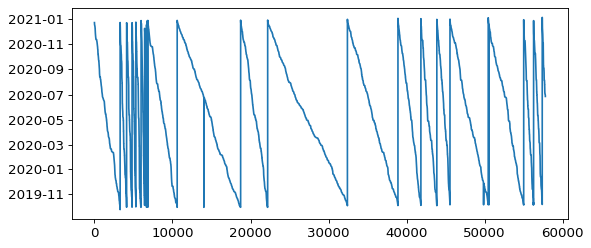

In [119]:
all_headlines_df['versionCreated'].plot()

In [39]:
quasi_logger

,ric_i,ric_now,headlines_slice_i,headlines_number,up_to_date_ric,story_i,story_id_now,story_is_success,date_time
0,0,DTEGn.DE,0,100,2020-12-24T03:51:28,0,urn:newsml:reuters.com:20201223:nNRAdspppv:1,True,2020-12-24 03:51:31.939240
1,0,DTEGn.DE,0,100,2020-12-24T03:51:28,1,urn:newsml:reuters.com:20201222:nGLF4Kt1L3:2,True,2020-12-24 03:51:33.740708
2,0,DTEGn.DE,0,100,2020-12-24T03:51:28,2,urn:newsml:reuters.com:20201222:nGLF2DBhZz:2,True,2020-12-24 03:51:37.079818
3,0,DTEGn.DE,0,100,2020-12-24T03:51:28,3,urn:newsml:reuters.com:20201221:nBw3VPZ4Qa:1,True,2020-12-24 03:51:37.803316
4,0,DTEGn.DE,0,100,2020-12-24T03:51:28,4,urn:newsml:reuters.com:20201219:nL8N2IY3D9:1,True,2020-12-24 03:51:38.957981
...,...,...,...,...,...,...,...,...,...
47603,9,BAYGn.DE,0,93,None,95,urn:newsml:reuters.com:20201218:nNRAdt1n41:1,True,2021-01-05 01:02:54.642019
47604,9,BAYGn.DE,0,93,None,96,urn:newsml:reuters.com:20201217:nNRAdsgj4j:1,True,2021-01-05 01:02:55.444882
47605,9,BAYGn.DE,0,93,None,97,urn:newsml:reuters.com:20201217:nNRAdsuxrf:1,True,2021-01-05 01:02:57.405627
47606,9,BAYGn.DE,0,93,None,98,urn:newsml:reuters.com:20201217:nPLA1ZGZm4:1,True,2021-01-05 01:02:59.010354


In [43]:
# Сохранить версию all_headlines_df
file_version = 1
folder_name = path_project_folder + folder_name_headlines
date_now = datetime.today().strftime("%Y-%m-%d")
file_name = 'all_headlines_df' + '_' + str(date_now) + '_v' + str(file_version) + '.csv'
while file_name in os.listdir(folder_name):
    file_name = 'all_headlines_df' + '_' + str(date_now) + '_v' + str(file_version) + '.csv'
    file_version = file_version + 1
# C:/DAN/t_systems/trade_project/backup_headlines/all_headlines_df_2020-12-24_v6.csv
file_path = folder_name + file_name
all_headlines_df.to_csv(file_path, sep = '~', index=False)
print(file_path)

C:/DAN/t_systems/trade_project/backup_headlines/all_headlines_df_2021-01-05_v6.csv


In [44]:
# Сохранить версию логгера
file_version = 1
folder_name = path_project_folder + folder_name_logger
date_now = datetime.today().strftime("%Y-%m-%d")
file_name = 'quasi_logger' + '_' + str(date_now) + '_v' + str(file_version) + '.csv'
while file_name in os.listdir(folder_name):
    file_name = 'quasi_logger' + '_' + str(date_now) + '_v' + str(file_version) + '.csv'
    file_version = file_version + 1
file_path = folder_name + file_name
quasi_logger.to_csv(file_path, sep = ';', index=False)
print(file_path)

C:/DAN/t_systems/trade_project/logger/quasi_logger_2021-01-05_v6.csv


In [121]:
print('df shape:', all_headlines_df.shape, ',  Num of rics:', all_headlines_df.groupby('ric')['ric'].nunique().sort_values(ascending=False).count())
print('StoryId duplicated:', all_headlines_df['storyId'].duplicated().sum())
print('Rows in df duplicated:', all_headlines_df.duplicated().sum())
print()
print('status error_when_trying_to_collect_story:', all_headlines_df[all_headlines_df['story'] == 'error_when_trying_to_collect_story']['story'].count())
print()
print('    Number of NA:')
print(len(all_headlines_df) - all_headlines_df.notna().sum())

df shape: (57785, 6) ,  Num of rics: 22
StoryId duplicated: 7438
Rows in df duplicated: 638

status error_when_trying_to_collect_story: 275

    Number of NA:
ric                 0
versionCreated      0
headline            0
storyId             0
sourceCode          0
story             153
dtype: int64
